In [1]:
from suffix_averaging import SuffixAveragingOptimizer
import os
import numpy as np
import pylab
from qiskit import IBMQ, Aer
from qiskit.utils import QuantumInstance
from qiskit.providers.aer.noise import NoiseModel

#General imports
import numpy as np

#Operator Imports
from qiskit.opflow import Z, X, I

from qiskit import Aer
from qiskit.opflow import X, Z, I

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SPSA, NFT, ADAM
from qiskit.circuit.library import TwoLocal

In [2]:
circ_params = []
def load_params(x):
    circ_params.append(x)

optimizers = [ADAM(maxiter=10)]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

In [3]:
H2_op = (-1.052373245772859 * I ^ I) + \
        (0.39793742484318045 * I ^ Z) + \
        (-0.39793742484318045 * Z ^ I) + \
        (-0.01128010425623538 * Z ^ Z) + \
        (0.18093119978423156 * X ^ X)

In [4]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_lima")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
quantum_instance = QuantumInstance(backend=backend, shots=500, noise_model=noise_model, coupling_map=coupling_map)

In [5]:
for i, optimizer in enumerate(optimizers):
    print('\rOptimizer: {}        '.format(type(optimizer).__name__), end='')
    algorithm_globals.random_seed = 50
    ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')

    counts = []
    values = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    path = os.getcwd()
    filename = "circ_params_"+type(optimizer).__name__
    suffix_optimizer = SuffixAveragingOptimizer(optimizer, suffix_dir = path, suffix_filename = filename, save_params=True, save_averaged_params=True, alpha = 0.3)

    vqe = VQE(ansatz, suffix_optimizer, callback=store_intermediate_result,
              quantum_instance=quantum_instance)
    result = vqe.compute_minimum_eigenvalue(operator=H2_op)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)

Optimizer: ADAM        

/Users/shirotamiya/.pyenv/versions/3.10.3/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/shirotamiya/.pyenv/versions/3.10.3/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


IndexError: index -1 is out of bounds for axis 0 with size 0

In [ ]:
suffix_results = SuffixAveragingOptimizer.read_circ_params(path, filename+"_suffix")

Optimization complete
sa_result -1.8175676159560983
prev_result -1.805483181899514
improvement 0.012084434056584215


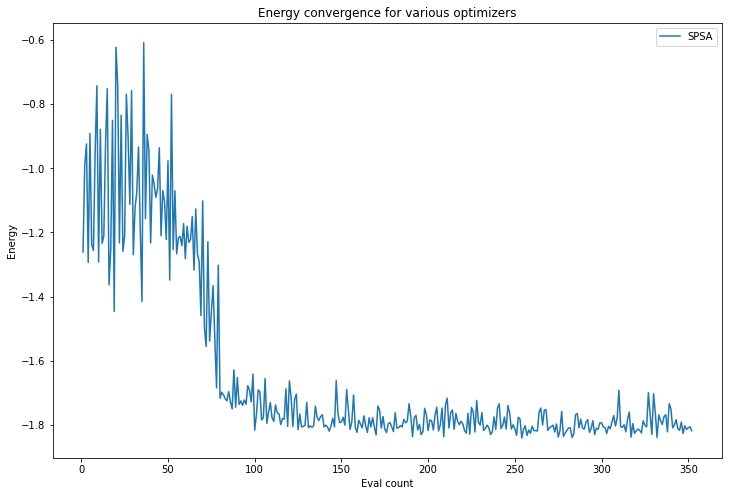

In [108]:
print('\rOptimization complete')
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right')
print("sa_result", result.optimal_value)
print("prev_result", converge_vals[0][-2])
print("improvement", converge_vals[0][-2]-result.optimal_value)